# Movie Recommendation Engine: Data Analysis and Visualization

#### The core dataset is contained in 3 main files, tag.csv - containing user generated tags, rating.csv - containing user ratings, movie.csv - containing movie master data.

#### User picks a genre they want to watch, then they get asked if they like a few (popular) movies [unless we can get autocomplete on the list], then a list of 3 movies is presented. Under the hood, we use ratings and tags to get list of movies calculating distances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity
data_dir = r"C:\Users\Ben\Documents\Data Sets\movielens_20m_dataset\\"

In [2]:
pd.set_option('display.max_rows', 20)

In [3]:
movies_master = pd.read_csv(data_dir+"movie.csv")

In [4]:
movies_master

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


## Manipulate movies data to show different genres

In [5]:
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [6]:
movies_master["genres"] = movies_master.genres.str.split('|')
movies = explode(movies_master, 'genres')

In [7]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure
1,1,Toy Story (1995),Animation
2,1,Toy Story (1995),Children
3,1,Toy Story (1995),Comedy
4,1,Toy Story (1995),Fantasy


In [8]:
movies["genres"].unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

#### Number of movies per genre

In [9]:
print(movies_master.title.nunique(), "movies in the dataset")

27262 movies in the dataset


In [10]:
movies.groupby("genres").title.nunique()

genres
(no genres listed)      246
Action                 3519
Adventure              2328
Animation              1025
Children               1138
Comedy                 8369
Crime                  2938
Documentary            2471
Drama                 13337
Fantasy                1412
Film-Noir               330
Horror                 2610
IMAX                    196
Musical                1036
Mystery                1514
Romance                4124
Sci-Fi                 1740
Thriller               4178
War                    1194
Western                 676
Name: title, dtype: int64

### Extract the year of movie

In [11]:
#Select the year and the extract it from the parenthases
movies_master["year"] = movies_master.title.str[-6:]\
                                     .str.extract('(\d+)', expand=False)\
                                     .astype(float)
movies_master["title"] = movies_master["title"].apply(lambda x: x.split("(")[0][:-1])

In [12]:
movies_master["title"]

0                                              Toy Story
1                                                Jumanji
2                                       Grumpier Old Men
3                                      Waiting to Exhale
4                            Father of the Bride Part II
5                                                   Heat
6                                                Sabrina
7                                           Tom and Huck
8                                           Sudden Death
9                                              GoldenEye
                              ...                       
27268                                  Ants in the Pants
27269                       Werner - Gekotzt wird später
27270                                     Brother Bear 2
27271                                     No More School
27272    Forklift Driver Klaus: The First Day on the Job
27273                              Kein Bund für's Leben
27274                          

### Which movies are most watched (most rated) per genre?

In [13]:
ratings = pd.read_csv(data_dir+"rating.csv")

In [14]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [15]:
popular_movies = ratings.groupby("movieId")\
                        .userId\
                        .count()\
                        .reset_index()
popular_movies.columns = ['movieId', 'num_user']
popular_movies = popular_movies.sort_values("num_user", ascending=False)

In [16]:
pd.merge(popular_movies, movies_master[movies_master.year == 2014], on = 'movieId').head(20)

,movieId,num_user,title,genres,year
0,109374,2230,"Grand Budapest Hotel, The","[Comedy, Drama]",2014.0
1,112852,2049,Guardians of the Galaxy,"[Action, Adventure, Sci-Fi]",2014.0
2,109487,1739,Interstellar,"[Sci-Fi, IMAX]",2014.0
3,111759,1666,Edge of Tomorrow,"[Action, Sci-Fi, IMAX]",2014.0
4,111362,1534,X-Men: Days of Future Past,"[Action, Adventure, Sci-Fi]",2014.0
5,112556,1479,Gone Girl,"[Drama, Thriller]",2014.0
6,110102,1261,Captain America: The Winter Soldier,"[Action, Adventure, Sci-Fi, IMAX]",2014.0
7,108932,1181,The Lego Movie,"[Action, Adventure, Animation, Children, Comed...",2014.0
8,112290,913,Boyhood,[Drama],2014.0
9,112183,840,Birdman,"[Comedy, Drama]",2014.0


In [17]:
print(sum(popular_movies.num_user < 30), "movies have less than 30 ratings")
popular_movies = popular_movies[popular_movies.num_user > 30]

14730 movies have less than 30 ratings


#### Can raters rate a movie more than once?

In [18]:
print("A user can rate a movie a maximum of", ratings.groupby(["userId","movieId"]).rating.count().max(), "time(s)")

A user can rate a movie a maximum of 1 time(s)


### Filter out unpopular movies

In [19]:
ratings = ratings[ratings["movieId"].isin(popular_movies["movieId"])]
movies = movies[movies["movieId"].isin(popular_movies["movieId"])]
movies_master = movies_master[movies_master["movieId"].isin(popular_movies["movieId"])]

### Movie Rating Similarity

#### Add 80 percentile calculation to each movie rating. Ratings better than or equal to this will include raters who "like" the movie

In [20]:
quartiles = ratings.groupby("movieId").rating.quantile(q=.8, interpolation = 'midpoint').reset_index()
quartiles.columns = ["movieId", "top_quintile"]

In [21]:
ratings = pd.merge(ratings, quartiles, on = "movieId")

In [22]:
ratings['liked'] = np.where(ratings['rating'] >= ratings['top_quintile'], 1, 0)

#### Build liked movie1, avg rating movie 2 dataframe

In [23]:
movies_to_calc = [1, 296, 2571, 109374, 112852, 112556]

#### !The below cell takes a long time to run. Is there a vectorized solution?

In [24]:
cols = ['ratedMovie', 'avgRating', 'countRating', 'likedMovie']
liked_rated = pd.DataFrame(columns=cols)
    
start_time = time.time()
# for movies in the unqiue list of movies 
# for movieId in movies_master['movieId']:
for movieId in movies_to_calc:

    movie = movieId
    print(movie)
    
    # create a bool to find raters who liked the movie 
    liked_movie_bool = (ratings['liked'] == 1) & (ratings['movieId'] == movie)
    
    # get all the user IDs for people who liked the movie
    liked_movie_users = ratings.loc[liked_movie_bool, 'userId']
    
    # create bool to find all rows for users who liked the movie 
    liked_movie_users_bool = ratings['userId'].isin(liked_movie_users)
    
    # for rows where reviewers liked the movie, get average rating and rating counts for all other movies
    liked_movie_rated = ratings[(liked_movie_users_bool) & (ratings.movieId!= movie)].groupby('movieId')['rating']\
                                                                                 .agg(['mean','count'])\
                                                                                 .reset_index()
    liked_movie_rated['likedMovie'] = movie
    
    liked_rated_snip = liked_movie_rated.loc[liked_movie_rated['count'] > 30, :]
    liked_rated_snip.columns = cols

    liked_rated = liked_rated.append(liked_rated_snip)

print("This cell took", (time.time() - start_time) / 60, "minutes to run")

1
296
2571
109374
112852
112556
This cell took 0.3915988524754842 minutes to run


### Movie Tag Similarity

In [25]:
liked_rated.groupby('likedMovie').count()

,ratedMovie,avgRating,countRating
likedMovie,,,
1,6355,6355,6355
296,8339,8339,8339
2571,7718,7718,7718
109374,2873,2873,2873
112556,1995,1995,1995
112852,2478,2478,2478


In [26]:
genome_scores = pd.read_csv(data_dir+'genome_scores.csv')

In [27]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [28]:
genome_scores = pd.pivot_table(genome_scores, values='relevance', index='movieId', columns='tagId').reset_index()

#### 10381 movies have 1129 tags

In [29]:
genome_scores.shape

(10381, 1129)

In [30]:
genome_scores.head()

tagId,movieId,1,2,3,4,5,6,7,8,9,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
0,1,0.02500,0.02500,0.05775,0.09675,0.14675,0.21700,0.06700,0.26275,0.26200,...,0.03950,0.01800,0.04575,0.03275,0.12500,0.04150,0.01925,0.03625,0.07775,0.02300
1,2,0.03975,0.04375,0.03775,0.04800,0.11025,0.07250,0.04775,0.10975,0.09925,...,0.04175,0.01925,0.01725,0.02425,0.12550,0.02250,0.01550,0.01475,0.09025,0.01875
2,3,0.04350,0.05475,0.02800,0.07700,0.05400,0.06850,0.05600,0.18500,0.04925,...,0.04150,0.02675,0.02775,0.03425,0.15550,0.03675,0.01700,0.01950,0.09700,0.01850
3,4,0.03725,0.03950,0.03675,0.03100,0.06825,0.04050,0.02325,0.08700,0.05125,...,0.05750,0.03375,0.02275,0.03975,0.18525,0.05925,0.01500,0.01525,0.06450,0.01300
4,5,0.04200,0.05275,0.05925,0.03675,0.07525,0.12525,0.02850,0.08500,0.02950,...,0.04250,0.02825,0.02150,0.02600,0.14275,0.02075,0.01650,0.01675,0.10750,0.01825


In [31]:
genome_scores = genome_scores[genome_scores['movieId'].isin(movies_master['movieId'])]

#### 10132 movies are "popular" (have been rated 30 times or more)

In [32]:
genome_scores.shape

(10132, 1129)

In [33]:
genome_similarity = cosine_similarity(genome_scores.iloc[:,1:])

In [34]:
genome_similarity.shape

(10132, 10132)

In [35]:
genome_similarity

array([[ 1.        ,  0.77436353,  0.70542151, ...,  0.52570615,
         0.52166691,  0.7093659 ],
       [ 0.77436353,  1.        ,  0.68651809, ...,  0.57391922,
         0.60039779,  0.60172596],
       [ 0.70542151,  0.68651809,  1.        , ...,  0.65508955,
         0.66859776,  0.73614652],
       ..., 
       [ 0.52570615,  0.57391922,  0.65508955, ...,  1.        ,
         0.63896909,  0.5480052 ],
       [ 0.52166691,  0.60039779,  0.66859776, ...,  0.63896909,
         1.        ,  0.60315815],
       [ 0.7093659 ,  0.60172596,  0.73614652, ...,  0.5480052 ,
         0.60315815,  1.        ]])

In [36]:
tagged_movieIds = list(genome_scores['movieId'])
genome_similarity = pd.DataFrame(genome_similarity, columns=tagged_movieIds)
genome_similarity['movieId'] = [int(mov) for mov in tagged_movieIds]

In [37]:
genome_similarity = genome_similarity[movies_to_calc + ['movieId']]

In [38]:
start_time = time.time()
genome_similarity = genome_similarity.melt(id_vars='movieId', var_name='movieId2', value_name='similarity')
print("This cell took", (time.time() - start_time) / 60, "minutes to run")

This cell took 8.35577646891276e-05 minutes to run


In [39]:
genome_similarity.head()

,movieId,movieId2,similarity
0,1,1,1.000000
1,2,1,0.774364
2,3,1,0.705422
3,4,1,0.653030
4,5,1,0.671112


In [40]:
genome_similarity = genome_similarity[genome_similarity.movieId != genome_similarity.movieId2]

### Add similarity scores together

In [41]:
scores = pd.merge(liked_rated, genome_similarity, how='left', left_on=['ratedMovie', 'likedMovie'], 
               right_on=['movieId', 'movieId2'])

In [42]:
scores.head()

,ratedMovie,avgRating,countRating,likedMovie,movieId,movieId2,similarity
0,2,3.521185,3375,1,2.0,1,0.774364
1,3,3.354500,2189,1,3.0,1,0.705422
2,4,2.968432,491,1,4.0,1,0.653030
3,5,3.301891,2274,1,5.0,1,0.671112
4,6,3.890141,3327,1,6.0,1,0.622978


In [43]:
scores['score'] = scores.avgRating / 20 + scores.similarity

In [44]:
max_score = scores['score'].max()
scores['score'] = max_score - scores['score']
scores = pd.merge(scores, movies_master[['title', 'movieId']], left_on='ratedMovie', right_on='movieId')

In [45]:
scores = scores[["likedMovie", "ratedMovie", "title", "avgRating", "countRating", "similarity", "score"]]

In [46]:
scores.describe()

,avgRating,similarity,score
count,29758.000000,29561.000000,29561.000000
mean,3.386306,0.639673,0.376422
std,0.570547,0.082779,0.099651
min,0.731481,0.361738,0.000000
25%,3.045455,0.584912,0.311994
50%,3.485269,0.636885,0.376587
75%,3.820513,0.692007,0.441766
max,4.639259,0.958831,0.727218


In [59]:
movie = movies_to_calc[2]
movie_name = movies_master.loc[movies_master.movieId==movie,"title"].values[0]
print("Movies like {}".format(movie_name))
scores[scores.likedMovie==movie].sort_values('score', ascending=True).head(10)

Movies like Matrix, The


,likedMovie,ratedMovie,title,avgRating,countRating,similarity,score
24165,2571,79132,Inception,4.424255,3591,0.899237,0.064922
15957,2571,5903,Equilibrium,3.987595,2620,0.905626,0.080367
25962,2571,111759,Edge of Tomorrow,4.098921,556,0.891040,0.089386
906,2571,260,Star Wars: Episode IV - A New Hope,4.450572,12503,0.872842,0.090001
1912,2571,541,Blade Runner,4.305285,8325,0.874347,0.095761
16574,2571,6365,"Matrix Reloaded, The",3.800370,5946,0.895890,0.099464
2049,2571,589,Terminator 2: Judgment Day,4.234971,12110,0.872689,0.100935
3899,2571,1240,"Terminator, The",4.180663,10229,0.874427,0.101912
25890,2571,109487,Interstellar,4.203422,526,0.872987,0.102215
3672,2571,1196,Star Wars: Episode V - The Empire Strikes Back,4.450944,12282,0.858581,0.104244


### Visualize results

#### Toy story

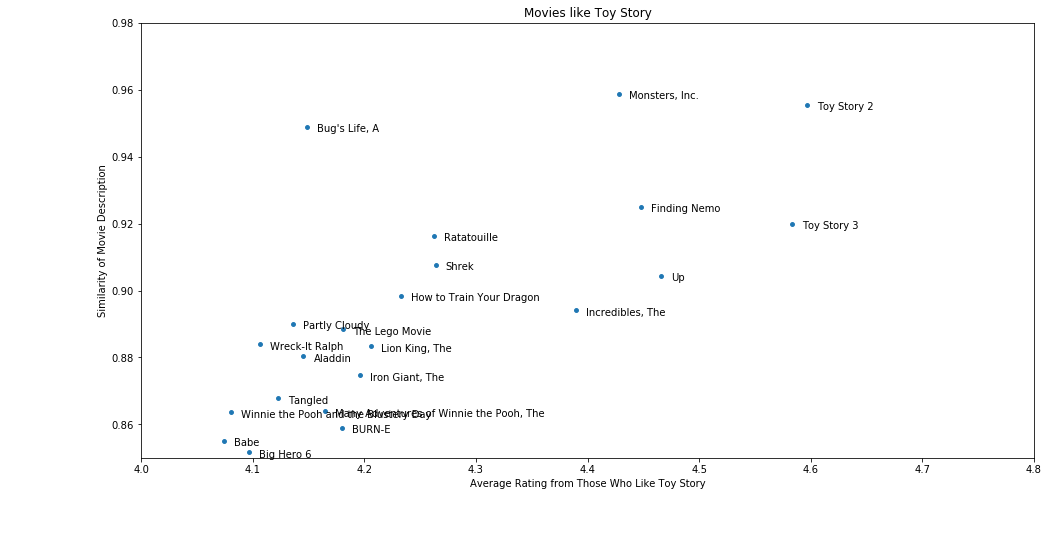

In [48]:
fig, ax = plt.subplots()
movie = movies_to_calc[0]
movie_name = movies_master.loc[movies_master.movieId==movie,"title"].values[0]
plot_df = scores[scores.likedMovie==movie]
plot_df.plot(x="avgRating", y="similarity", kind='scatter', title="Movies like {}".format(movie_name), 
                                 xlim=(4, 4.8), ylim=(.85, .98), ax=ax, figsize=(16, 8), s=15)
ax.set_xlabel("Average Rating from Those Who Like {}".format(movie_name))
ax.set_ylabel("Similarity of Movie Description")

for index, row in plot_df.iterrows():
    ax.annotate(row.title, [row.avgRating, row.similarity], textcoords='offset points', xytext=(10,-5))

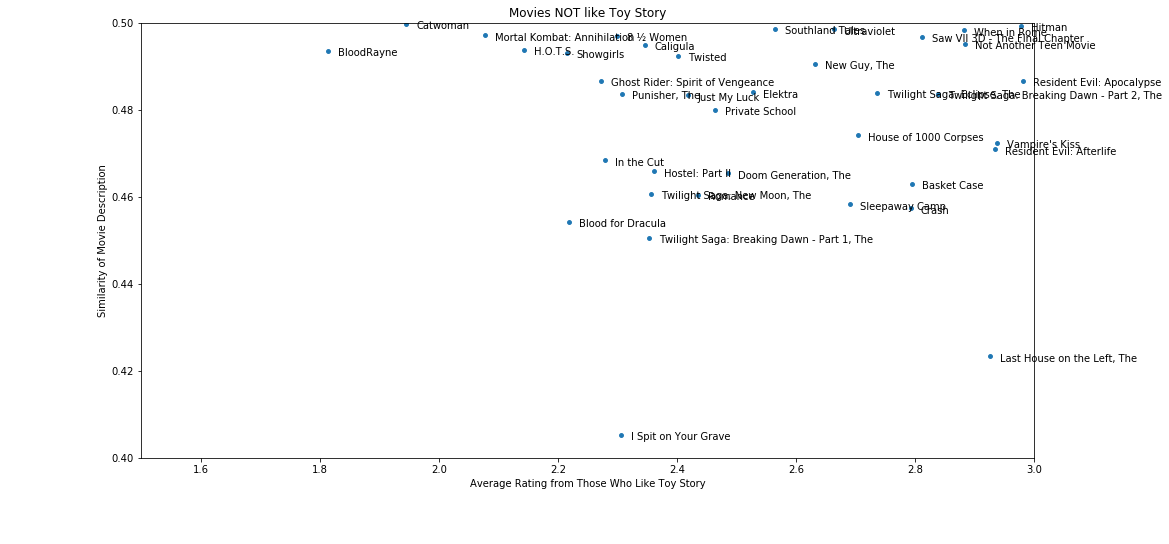

In [52]:
fig, ax = plt.subplots()
movie = movies_to_calc[0]
movie_name = movies_master.loc[movies_master.movieId==movie,"title"].values[0]
plot_df = scores[scores.likedMovie==movie]
plot_df.plot(x="avgRating", y="similarity", kind='scatter', title="Movies NOT like {}".format(movie_name), 
                                 xlim=(1.5, 3), ylim=(.4, .5), ax=ax, figsize=(16, 8), s=15)
ax.set_xlabel("Average Rating from Those Who Like {}".format(movie_name))
ax.set_ylabel("Similarity of Movie Description")
for index, row in plot_df.iterrows():
    ax.annotate(row.title, [row.avgRating, row.similarity], textcoords='offset points', xytext=(10,-5))

#### Pulp Fiction

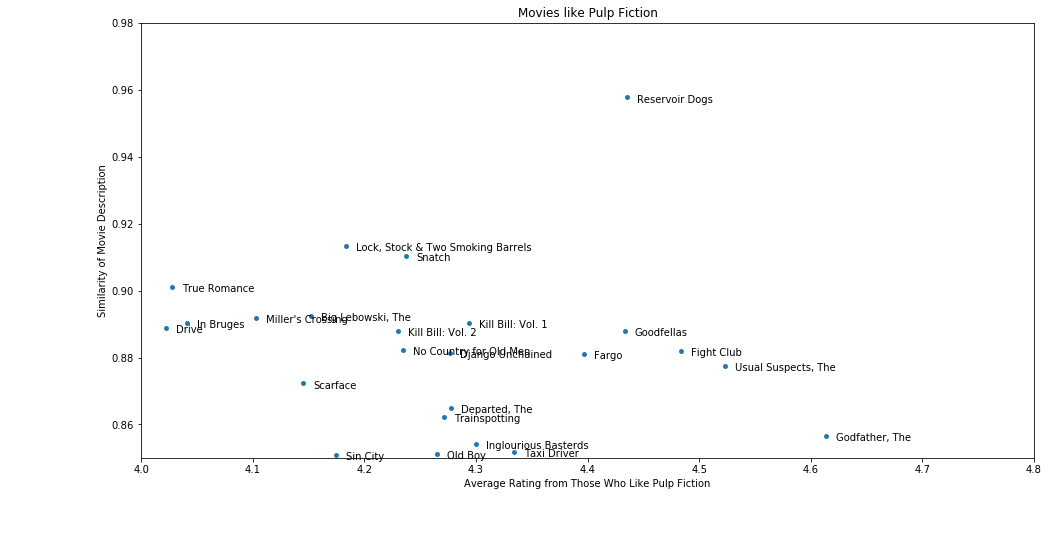

In [53]:
fig, ax = plt.subplots()
movie = movies_to_calc[1]
movie_name = movies_master.loc[movies_master.movieId==movie,"title"].values[0]
plot_df = scores[scores.likedMovie==movie]
plot_df.plot(x="avgRating", y="similarity", kind='scatter', title="Movies like {}".format(movie_name), 
                                 xlim=(4, 4.8), ylim=(.85, .98), ax=ax, figsize=(16, 8), s=15)
ax.set_xlabel("Average Rating from Those Who Like {}".format(movie_name))
ax.set_ylabel("Similarity of Movie Description")
for index, row in plot_df.iterrows():
    ax.annotate(row.title, [row.avgRating, row.similarity], textcoords='offset points', xytext=(10,-5))

#### The Grand Budapest Hotel

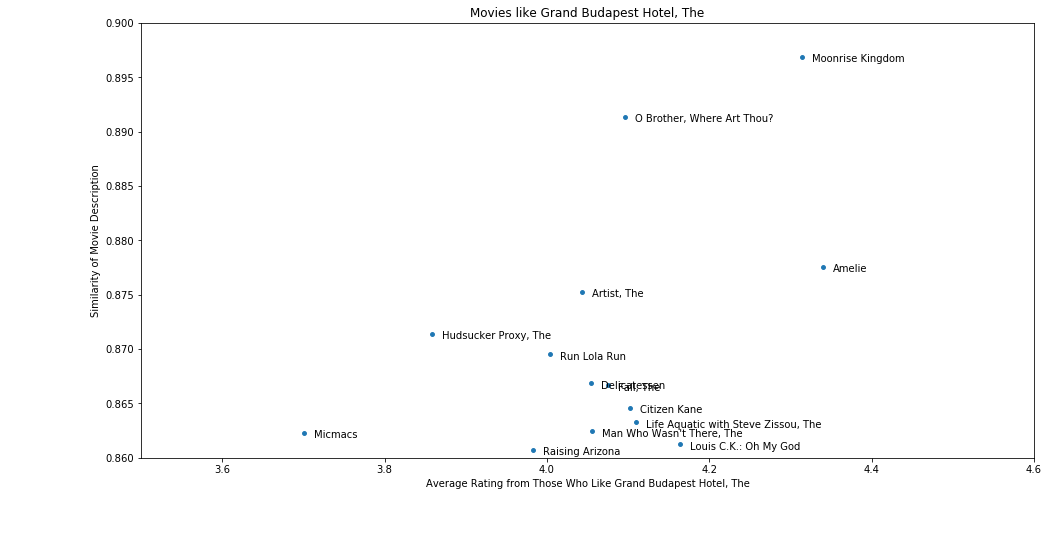

In [58]:
fig, ax = plt.subplots()
movie = movies_to_calc[3]
movie_name = movies_master.loc[movies_master.movieId==movie,"title"].values[0]
plot_df = scores[scores.likedMovie==movie]
plot_df.plot(x="avgRating", y="similarity", kind='scatter', title="Movies like {}".format(movie_name), 
                                 xlim=(3.5, 4.6), ylim=(.86, .9), ax=ax, figsize=(16, 8), s=15)
ax.set_xlabel("Average Rating from Those Who Like {}".format(movie_name))
ax.set_ylabel("Similarity of Movie Description")
for index, row in plot_df.iterrows():
    ax.annotate(row.title, [row.avgRating, row.similarity], textcoords='offset points', xytext=(10,-5))

## Conclusion: Average rating of the movie does not have a very meaningful impact on movie similarity. Raters can like two very different movies. Movie tag similarity is key